<a href="https://colab.research.google.com/github/hhaeri/NLP-with-Yelp-reviews/blob/main/NLP_with_Yelp_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing using Yelp Reviews  

Unstructured data makes up the vast majority of data.  This is a basic intro to handling unstructured data.  The objective is to be able to extract the sentiment (positive or negative) and gain insight from review text.  I will do this from Yelp review data. In this project I will:


*   Build models of increasing complexity (bag of words and bigram models) to predict the rating of a review from its text
*   Build a Naive Bayes model to determine the most "polarizing words" in the corpus of reviews. That is, to identify words that strongly signal a review is either positive or negative

*   Analyze the reviews of restaurants to find collocations --- that is, food bigrams that are "special" and appear more often than you'd expect from chance





In [1]:
import seaborn as sns
sns.set()

In [3]:
# I prefer using jsonlines over json
# It allows for storing structured data that may be processed one record at a time
!pip install -q jsonlines

In [4]:
import pandas as pd
import pickle
import random
import os
import jsonlines

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download and parse the data


To start, let's download the data set from kaggle datasets [here](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset) or alternatively directly download the dataset to google drive using Kaggle's API

In [6]:
%%time
'''This Yelp review dataset is huge (~7M reviews) and I can't fit it my System
RAM and I am not able to train my model in colab. So I decided to randomly
select 10% of the dataset (700k reviews) and train my model with that
'''
review_text_file = '/content/drive/MyDrive/Colab Notebooks/yelp_dataset/yelp_academic_dataset_review.json'
sample_size= 700000
dataset = []
with jsonlines.open(review_text_file) as reader:
    for obj in reader:
      if random.random()<(sample_size/(sample_size+1)):
        review_text_data = {}
        review_text_data['business_id']=obj['business_id']
        review_text_data['stars']=obj['stars']
        review_text_data['text']=obj['text']
        dataset.append(review_text_data)
        if len(dataset)>=sample_size:
          break


CPU times: user 8.4 s, sys: 984 ms, total: 9.39 s
Wall time: 16.2 s


In [7]:
len(dataset)

700000

The scikit-learn API requires that we keep labels (in this case, the star ratings) and features in separate data structures.

In [8]:
stars = [row['stars'] for row in dataset]

In [ ]:
pd.DataFrame.from_dict(dataset)

,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...
...,...,...,...
699995,DvkSkF83xDONjkNIoEPRnQ,5.0,This place is amazing. I'm very surprised seei...
699996,Y3ZCO17N1_T_Ms1JmswwzA,4.0,"Horchata was good, and the tortillas were grea..."
699997,f4vbnGoGo3eWorVekctVGQ,5.0,Best omelette and grits both my girlfriend and...
699998,L3QX19EWlkS-clS68Boydg,4.0,Stopped in to grab an order of beignets becaus...


## Section 1: bag_of_words_model

In this section I build a linear model predicting the star rating based on the text reviews. I apply the bag-of-words model using the [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to produce a feature matrix giving the counts of each word in each review.


1. I Tried choosing different values for `min_df` (minimum document frequency cutoff) and `max_df` in `CountVectorizer`. Setting `min_df` to zero admits rare words which might only appear once in the entire corpus.  This is both prone to overfitting and makes your data unmanageably large.  

1. I performed hyperparameter tuning between the vectorization step and the regularization of the predictor. While it is more strictly correct to do a grid search over all of them at once, this can take a long time. Quite often, doing a grid search over a single hyperparameter at a time can produce similar results.  Alternatively, the grid search may be done over a smaller subset of the data, as long as it is representative of the whole.

1. Finally, I assembled a pipeline that  transforms the data from list of dictionaries all the way to predictions.  

**Limitations of Bag-of-Words**

1.   The model ignores the location information of the word. The location information is a piece of very important information in the text. For example “today is off” and “Is today off”, have the exact same vector representation in the BoW model.

1.   Bag of word models doesn’t respect the semantics of the word. For example, words ‘soccer’ and ‘football’ are often used in the same context. However, the vectors corresponding to these words are quite different in the bag of words model. The problem becomes more serious while modeling sentences. Ex: “Buy used cars” and “Purchase old automobiles” are represented by totally different vectors in the Bag-of-words model.

1.   The range of vocabulary is a big issue faced by the Bag-of-Words model. For example, if the model comes across a new word it has not seen yet, rather we say a rare, but informative word like Biblioklept(means one who steals books). The BoW model will probably end up ignoring this word as this word has not been seen by the model yet.




In [9]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin

class ReviewtoText(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self

    def transform(self, X):
        # Extract the text from data (X) and Return a 1D array of text from X
        review_text = [row['text'] for row in X]
        return review_text

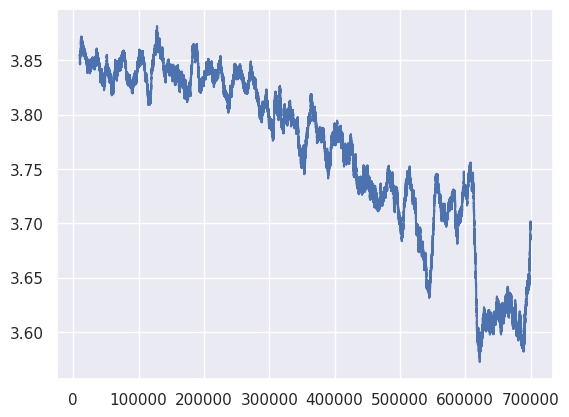

In [10]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(stars), window=10000).mean());
# the following plot is showing the rolling mean of the star ratings, it seems the data needs shuffling

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
# Removing a few words that don't lemmatize well
STOP_WORDS = STOP_WORDS.difference({'he','his','her','hers'})
stop_words = STOP_WORDS

In [ ]:
from sklearn import metrics
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging

pipeline = Pipeline(
    [   ('transformer',ReviewtoText()),
        ("vect", CountVectorizer(stop_words = list(stop_words))),
        ("lsgd", SGDRegressor()),
    ]
)

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    "vect__min_df": [5],
    "vect__max_df": [0.9],
    # 'vect__max_features': (None, 5000, 10000, 50000),
    #"vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    "lsgd__max_iter": (100,),
    "lsgd__alpha": (0.00001, 0.000001),
    "lsgd__penalty": ["l2"],#, "elasticnet"),
}

bag_of_words_model = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)


In [ ]:
from sklearn.model_selection import train_test_split
from random import shuffle
import random
#I am using train_test_split thus the data shuffling is taken care of
X_train, X_test, y_train, y_test = train_test_split(dataset, stars, test_size = 0.2,
                                                    random_state=42)

In [ ]:
from sklearn import set_config
set_config(display='diagram')


In [ ]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
bag_of_words_model.fit(X_train, y_train)

Performing grid search...
pipeline: ['transformer', 'vect', 'lsgd']
parameters:
{'lsgd__alpha': (1e-05, 1e-06),
 'lsgd__max_iter': (100,),
 'lsgd__penalty': ['l2'],
 'vect__max_df': [0.9],
 'vect__min_df': [5]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=Pipeline(steps=[('transformer', ReviewtoText()),
                                       ('vect',
                                        CountVectorizer(stop_words=['well',
                                                                    'did',
                                                                    'front',
                                                                    'nevertheless',
                                                                    'moreover',
                                                                    'three',
                                                                    'though',
                                                                    'being',
                                                                    '‘d', 'no',
                                                                    'thereupon',
                                                                    'until',
                                                                    "n't",
                                                                    'just',
                                                                    'do',
                                                                    'each',
                                                                    'thus',
                                                                    'full',
                                                                    'via', "'m",
                                                                    'does',
                                                                    'afterwards',
                                                                    'across',
                                                                    'must',
                                                                    'same',
                                                                    'were',
                                                                    'latter',
                                                                    '’ve',
                                                                    'are',
                                                                    'see', ...])),
                                       ('lsgd', SGDRegressor())]),
             n_jobs=-1,
             param_grid={'lsgd__alpha': (1e-05, 1e-06),
                         'lsgd__max_iter': (100,), 'lsgd__penalty': ['l2'],
                         'vect__max_df': [0.9], 'vect__min_df': [5]},
             verbose=1)

In [ ]:
bag_of_words_model.score(X_test,y_test)

0.5695811605525896

In [ ]:
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % bag_of_words_model.best_score_)
print("Best parameters set:")
best_parameters = bag_of_words_model.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

done in 553.000s

Best score: 0.565
Best parameters set:
	lsgd__alpha: 1e-05
	lsgd__max_iter: 100
	lsgd__penalty: 'l2'
	vect__max_df: 0.9
	vect__min_df: 5


## Section 2 : bigram_model

In previous section I just built predicting the star ratings of resturants based on the presence of singular words in the model. Now what if the word "good" is accompanied with "not" and instead of a possitive review it is a negative review? The previous model can't handle this correctly. The bigram_model is aiming to help with this such that it looks at the pairs of words appearance rather than the appearnace of a word by itself in a given review.

In a bigram model, we'll consider both single words and pairs of consecutive words that appear. This is going to be a much higher-dimensional problem so we should be careful about overfitting. For this part I use a vectorizer that applies some sort of normalization, e.g., the `TfidfVectorizer` or a word count vectorizer combined with `TfidfTransformer`.

Sometimes, reducing the dimension can be useful. We can change the `max_features` hyperparameter to reduce the size of the resulting vocabulary. For `HashingVectorizer`, we can adjust the size of the feature matrix through `n_features`.



In [ ]:
from sklearn import metrics
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
# Removing a few words that don't lemmatize well
STOP_WORDS = STOP_WORDS.difference({'he','his','her','hers'})
stop_words = STOP_WORDS


pipeline_tfidf = Pipeline(
    [   ('transformer',ReviewtoText()),
        #('tokenizer', Tokenizer()),
        #('stopwords', StopWordRemover()),
        #('lemmatizer', Lemmatizer()),
        ("tfidfv", TfidfVectorizer(stop_words=list(stop_words))),
        ("lsgd", SGDRegressor()),
    ]
)

parameters = {
    'tfidfv__ngram_range': ((1,2),),
    'tfidfv__min_df': [5],
    'tfidfv__max_df': [0.9],
    'tfidfv__max_features':[5000],
    "lsgd__max_iter": [100],
    "lsgd__alpha": (0.00001,),# 0.000001),
    "lsgd__penalty": ["l2"],#, "elasticnet"),
}

bigram_model = GridSearchCV(pipeline_tfidf, parameters, n_jobs=-1, verbose=1)

In [ ]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_tfidf.steps])
print("parameters:")
pprint(parameters)
t0 = time()
bigram_model.fit(X_train, y_train)

Performing grid search...
pipeline: ['transformer', 'tfidfv', 'lsgd']
parameters:
{'lsgd__alpha': (1e-05,),
 'lsgd__max_iter': [100],
 'lsgd__penalty': ['l2'],
 'tfidfv__max_df': [0.9],
 'tfidfv__max_features': [5000],
 'tfidfv__min_df': [5],
 'tfidfv__ngram_range': ((1, 2),)}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('transformer', ReviewtoText()),
                                       ('tfidfv',
                                        TfidfVectorizer(stop_words=['well',
                                                                    'did',
                                                                    'front',
                                                                    'nevertheless',
                                                                    'moreover',
                                                                    'three',
                                                                    'though',
                                                                    'being',
                                                                    '‘d', 'no',
                                                                    'thereupon',
                                                                    'until',
                                                                    "n't",
                                                                    'just',
                                                                    'do',
                                                                    'each',
                                                                    'thus',
                                                                    'full',
                                                                    'via', "'m",
                                                                    'does',
                                                                    'afterwards',
                                                                    'across',
                                                                    'must',
                                                                    'same',
                                                                    'were',
                                                                    'latter',
                                                                    '’ve',
                                                                    'are',
                                                                    'see', ...])),
                                       ('lsgd', SGDRegressor())]),
             n_jobs=-1,
             param_grid={'lsgd__alpha': (1e-05,), 'lsgd__max_iter': [100],
                         'lsgd__penalty': ['l2'], 'tfidfv__max_df': [0.9],
                         'tfidfv__max_features': [5000], 'tfidfv__min_df': [5],
                         'tfidfv__ngram_range': ((1, 2),)},
             verbose=1)

In [ ]:
bigram_model.score(X_test,y_test)

0.6713481814775779

In [ ]:
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % bigram_model.best_score_)
print("Best parameters set:")
best_parameters = bigram_model.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

done in 761.078s

Best score: 0.664
Best parameters set:
	lsgd__alpha: 1e-05
	lsgd__max_iter: 100
	lsgd__penalty: 'l2'
	tfidfv__max_df: 0.9
	tfidfv__max_features: 5000
	tfidfv__min_df: 5
	tfidfv__ngram_range: (1, 2)


## Section 3: word_polarity

Let's consider a different approach and try to derive some insight from our analysis.  

In this section, I want to determine the most "polarizing words" in the corpus of reviews.  In other words, I want to identify words that strongly signal a review is either positive or negative.  For example, a word like "terrible" will most likely appear in negative rather than positive reviews.  

During training, the [naive Bayes model](https://scikit-learn.org/stable/modules/naive_bayes.html#) calculates probabilities such as $Pr(\textrm{terrible}\ |\ \textrm{negative}),$ the probability that the word "terrible" appears in the review text, given that the review is negative.  Using these probabilities, we can define a **polarity score** for each word $w$,

$$\textrm{polarity}(w) = \log\left(\frac{Pr(w\ |\ \textrm{positive})}{Pr(w\ |\ \textrm{negative})}\right).$$

Polarity analysis is an example where a simpler model (naive Bayes) offers more explicability than more complicated models.  Aside from this, naive Bayes models are easy to train, the training process is parallelizable, and these models lend themselves well to online learning.  Given enough training data, naive Bayes models have performed well in NLP applications such as spam filtering.  

For this problem, I am going to determine the top 25 most positive polar words and the 25 most negative polar words.  For this analysis, I took the following steps:

1.  **Filtered** the collection of reviews I was using above to **only keep** the one-star and five-star reviews. Since these are the "most polar" reviews, it should give me the most polarizing words.   
1.  Used the naive Bayes model, `MultinomialNB`.  
1.  Used TF-IDF weighting.
1.  Removed stop words.
1.  Generated a (Python) dataframe with most positive (25 words) and most negative (25 words) polar words.  

A naive Bayes model (after training) stores the log of the probabilities in an attribute of the model.  It is a `numpy` array of shape (number of classes, number of features).  I will need the mapping between feature indices to words to find the most polarizing words.  

In [54]:
polar_data = [d for d in dataset if ((d['stars'] == 5)|(d['stars'] == 1))]

In [55]:
polar_stars = [row['stars'] for row in polar_data]

In [56]:
len(polar_data)

430823

In [57]:
from sklearn.model_selection import train_test_split
from random import shuffle
import random

X_train, X_test, y_train, y_test = train_test_split(polar_data, polar_stars, test_size = 0.2,
                                                    random_state=42)

In [58]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

STOP_WORDS = STOP_WORDS.union({'ll', 've'})
# Removing a few words that don't lemmatize well
STOP_WORDS = STOP_WORDS.difference({'he','his','her','hers'})
stop_words = STOP_WORDS

est = Pipeline([('transformer',ReviewtoText()),
                ('vectorizer', TfidfVectorizer(min_df = 5, max_df=.9, stop_words=list(stop_words))),
                ('classifier', MultinomialNB())])


In [59]:
est.fit(X_train,y_train)
est.score(X_test,y_test)

0.942145882899089

In [60]:
#this gives the words in reviews and the location of each of these words in the vector
vocab = est.get_params()['vectorizer'].vocabulary_

In [61]:
vect = est.named_steps['vectorizer']

In [62]:
# vect.get_feature_names()

In [63]:
len(vocab)

39009

In [64]:
classnb = est.get_params()['classifier']

In [65]:
classnb.classes_

array([1., 5.])

In [86]:
polarity_df = pd.DataFrame({'word':sorted(vocab),'polarity':classnb.feature_log_prob_[1,:]-classnb.feature_log_prob_[0,:]}).sort_values('polarity',ascending = False)

In [107]:
polar_words = pd.concat([polarity_df.head(25).rename(columns={'word':'possitive words'}).reset_index(drop = True),polarity_df.tail(25).rename(columns={'word':'negative words'}).reset_index(drop=True)],axis = 1)

In [108]:
polar_words

,possitive words,polarity,negative words,polarity
0,gem,4.008188,unethical,-4.005243
1,phenomenal,3.792587,filthy,-4.006113
2,perfection,3.748598,pathetic,-4.062303
3,refreshing,3.711326,crooks,-4.066053
4,cozy,3.667551,liars,-4.082151
5,delicious,3.662294,refund,-4.084198
6,divine,3.616919,cockroach,-4.085204
7,delish,3.581297,scam,-4.106572
8,impeccable,3.451186,unsanitary,-4.111084
9,yummy,3.434062,fraudulent,-4.122323


## Section 4: food_bigrams

In this section, I want to find collocations --- that is, bigrams that are "special" and appear more often than you'd expect from chance. One can think of the corpus as defining an empirical distribution over all *n*-grams.  Word pairs that are unlikely to occur consecutively can be found based on the underlying probability of their words. Mathematically, if $p(w)$ be the probability of a word $w$ and $p(w_1 w_2)$ is the probability of the bigram $w_1 w_2$, then we want to look at word pairs $w_1 w_2$ where the statistic

  $$ \frac{p(w_1 w_2)}{p(w_1) p(w_2)} $$

is high.  

This statistic is a ratio and problematic when the denominator is small.  In order to fix this a Bayesian smoothing is applied to $p(w)$ (i.e. mixing the empirical distribution with the uniform distribution over the vocabulary). It should be noted that changing this smoothing parameter affects the word pairs you get qualitatively.As you adjust the size of the Bayesian smoothing parameter, you will notice first nonsense phrases being removed and then legitimate bigrams being removed, leaving you with only generic bigrams.  The goal is to find a value of the smoothing parameter between these two transitions.


Estimating the probabilities is simply a matter of counting, and there are number of approaches that will work.  One is to use one of the tokenizers to count up how many times each word and each bigram appears in each review, and then sum those up over all reviews.  You might want to know that the `CountVectorizer` has a `.get_feature_names_out()` method which gives the string associated with each column.  

There are a few reviews that include the same nonsense strings multiple times.  To keep these from showing up in our results, we set `min_df=10`, to ensure that a bigram occurs in at least 10 reviews before we consider it.


For this section I am only interested in food related reviews, so I need to filter the reviews for restaurarants. Here are the steps I took:




*   Find restaurants: Used the yelp_academic_dataset_business.json file from the Kaggle website to determine which businesses are restaurants and extract their business_id
*    Find Restaurant Reviews: Filtered the reviews that have business_ids matched with the extracted business_ids in the previous step
*   Find unigrams and bigrams counts: Used Scikit-learn CountVectorizer to get the counts of uni- and bi-grams
*   Used the probabailty of the bigrams and the unigrams to find the 25 most probable food bigrams

In [11]:
yelp_business_reviews = '/content/drive/MyDrive/Colab Notebooks/yelp_dataset/yelp_academic_dataset_business.json'
restaurants = []
#restaurant = {}
with jsonlines.open(yelp_business_reviews) as business_data:
    for obj in business_data:
      restaurant = {}
      if obj['categories'] is not None and 'restaurants' in (obj['categories']).lower():
        # Each row of this file corresponds to a single business. The categories key gives
        # a list of categories for each; I take all where "Restaurants" appears.
        restaurant['business_id']=obj['business_id']
        restaurant['categories']=obj['categories']
        restaurant['stars']=obj['stars']
        restaurants.append(restaurant)


In [12]:
len(restaurants)

52268

In [13]:
restaurant_ids = set([row['business_id'] for row in restaurants])

In [14]:
len(restaurant_ids)==len(restaurants)

True

In [15]:
'''The "business_id" here is the same as in the review data. I use this to
extract the review text for all reviews of restaurants.'''
restaurant_reviews = [d for d in dataset if (d['business_id'] in restaurant_ids )]

In [16]:
len(restaurant_reviews)

468131

In [17]:
restaurant_reviews_text = [row['text'] for row in restaurant_reviews]

In [18]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

STOP_WORDS = STOP_WORDS.union({'ll', 've'})
# Removing a few words that don't lemmatize well
STOP_WORDS = STOP_WORDS.difference({'he','his','her','hers'})

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(min_df = 10, stop_words=list(STOP_WORDS), ngram_range = (1, 2) )

In [20]:
%%time
counts = cv.fit_transform(restaurant_reviews_text)

CPU times: user 1min 18s, sys: 2.22 s, total: 1min 20s
Wall time: 1min 29s


In [21]:
df = pd.DataFrame({'ngram':cv.get_feature_names_out(),'count':counts.sum(axis=0).A1})

In [22]:
df_bi = df[df['ngram'].str.contains(' ')].rename(columns={'count':'bigram_count','ngram':'bigram'})

In [23]:
df_uni = df[~df['ngram'].str.contains(' ')].rename(columns={'count':'uni_count','ngram':'unigram'})

In [24]:
bi_split = df_bi['bigram'].str.split()
df_bi['w1']=bi_split.apply(lambda l:l[0])
df_bi['w2']=bi_split.apply(lambda l:l[1])

In [36]:
merged_df = df_bi.merge(df_uni,left_on='w1',right_on='unigram').merge(df_uni,left_on='w2',right_on='unigram')

In [50]:
smoothing = 30
merged_df['prob']=100*merged_df['bigram_count']/((merged_df['uni_count_x']+smoothing)*(merged_df['uni_count_y']+smoothing))

In [51]:
df_top25=merged_df.sort_values(["prob"],ascending = False).head(25)

In [52]:
df_top25

,bigram,bigram_count,w1,w2,unigram_x,uni_count_x,unigram_y,uni_count_y,prob
264693,hoity toity,31,hoity,toity,hoity,32,toity,31,0.819672
260427,duling kurtz,20,duling,kurtz,duling,20,kurtz,20,0.800000
266856,pecker wrecker,23,pecker,wrecker,pecker,23,wrecker,26,0.774933
265848,lok lak,18,lok,lak,lok,19,lak,19,0.749688
150506,abu sayf,23,abu,sayf,abu,28,sayf,23,0.748211
268415,zig zag,27,zig,zag,zig,35,zag,27,0.728745
267999,suis generis,24,suis,generis,suis,30,generis,25,0.727273
267129,poca cosa,22,poca,cosa,poca,22,cosa,29,0.717080
264692,hodge podge,19,hodge,podge,hodge,21,podge,22,0.716440
252578,bánh mì,30,bánh,mì,bánh,36,mì,34,0.710227


<Axes: xlabel='bigram'>

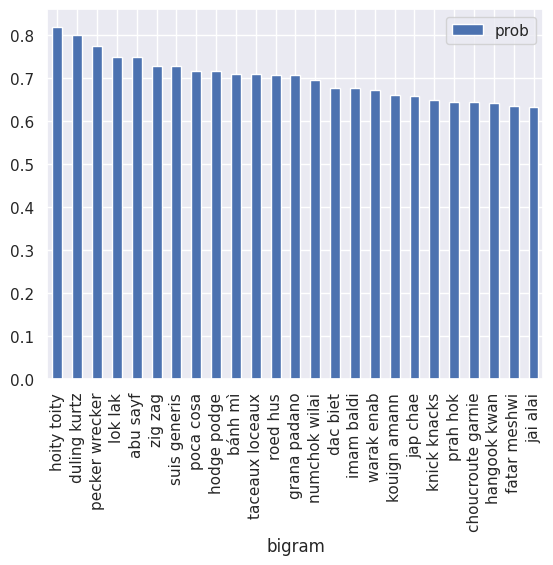

In [53]:
df_top25.plot.bar(x = 'bigram',y = 'prob' )

As lots of these bigrams were a mystery to me, I searched some of them and found them popular restaurants or dishes from Vietnam, Phillipine, South Asia, Turkey ,etc. If you are curious about them here are some links:


*   [lok lak](https://www.madewithsabrina.com/post/lok-lak-cambodian-shaking-beef#:~:text=Lok%20lak%2C%20known%20as%20shaking,country%20having%20their%20own%20variation.)
*   [Banh Mi](https://www.allrecipes.com/recipe/187342/banh-mi/)
*   [Grana Padano](https://en.wikipedia.org/wiki/Grana_Padano)
*  [imam Baldi](https://www.mygreekdish.com/recipe/imam-bayildi-recipe/)



In [180]:
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:


########################################################################
# Finding the important word combinations using textblob
from textblob import TextBlob

# Converting the sample text to a blob
TextInBlobFormat = TextBlob('. '.join(restaurant_reviews_text))

# Finding the noun phrases (important keywords combination) in the text
# This can help to find out what entities are being talked about in the given text
NounPhrases=TextInBlobFormat.noun_phrases

# Creating an empty list to hold new values
# combining the noun phrases using underscore to visualize it as wordcloud
NewNounList=[]
for words in NounPhrases:
    NewNounList.append(words.replace(" ", "_"))

# Converting list into a string to plot wordcloud
NewNounString=' '.join(NewNounList)
print('##### Important word combinations ####')
print(NewNounString)

In [ ]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(NewNounString)
# declare our figure
plt.figure(figsize=(20,10))
plt.title("Top Reviewed words", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

What Restaurants has got more reviews ?

In [154]:
most_reviewed_rest = pd.DataFrame.from_dict(restaurant_reviews).groupby('business_id').agg({'business_id':'count','stars':'mean'})\
.rename(columns={'business_id':'count','stars':'mean_stars'}).reset_index().sort_values('count',ascending=False).head(20)


## Word Cloud
This last section is to provide a visual of words that appear in top rated retaurants as well as polar reviews (stars = 1 and stars = 5) of al businesses

Word Cloud for Top reviewed restaurants


In [128]:
from collections import Counter
# wordcloud in python
from wordcloud import WordCloud, STOPWORDS

import re
import string
import nltk # preprocessing text
from textblob import TextBlob

In [147]:
df_restaurant_reviews = pd.DataFrame.from_dict(restaurant_reviews)
yelp_most_reviewd_res = df_restaurant_reviews.loc[df_restaurant_reviews['business_id'].isin(most_reviewed_rest['business_id'])]


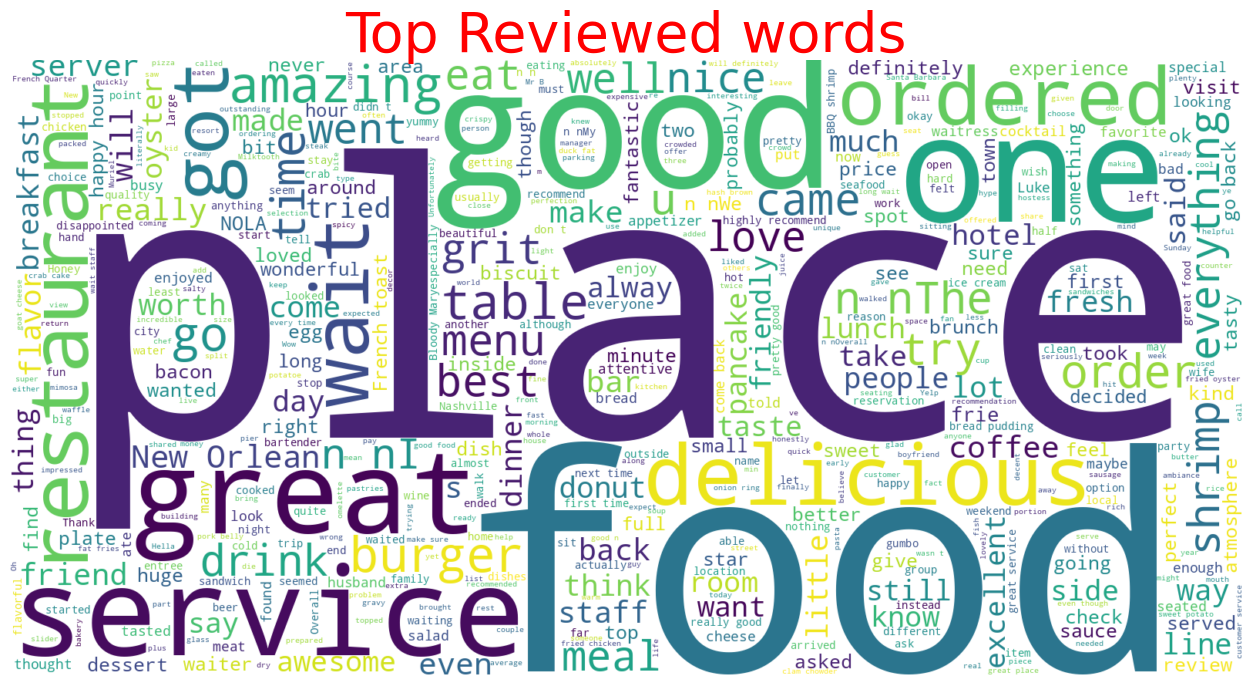

In [140]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(yelp_most_reviewd_res['text'])))
# declare our figure
plt.figure(figsize=(20,10))
plt.title("Top Reviewed words", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

Word Cloud for Possitive Reviews of all bussinesses


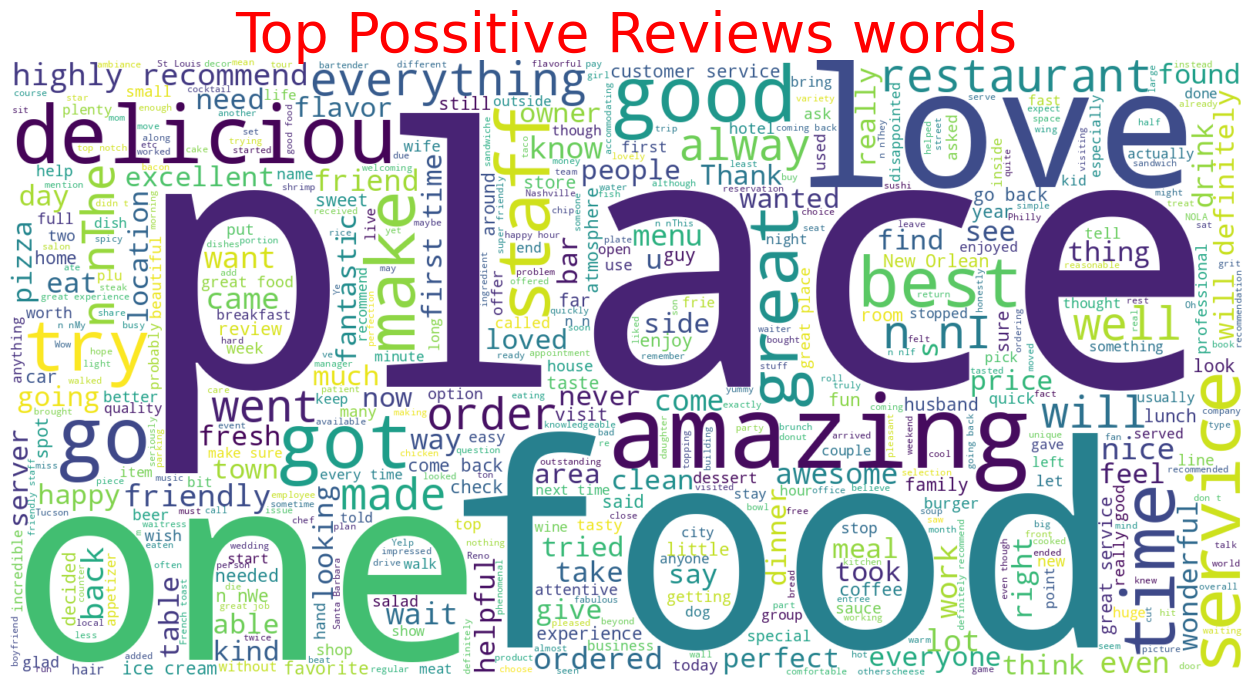

In [151]:
possitive_reviews = pd.DataFrame.from_dict([d for d in dataset if d['stars'] == 5])
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(possitive_reviews['text'])))
# declare our figure
plt.figure(figsize=(20,10))
plt.title("Top Possitive Reviews words", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

Word Cloud for Negative Reviews


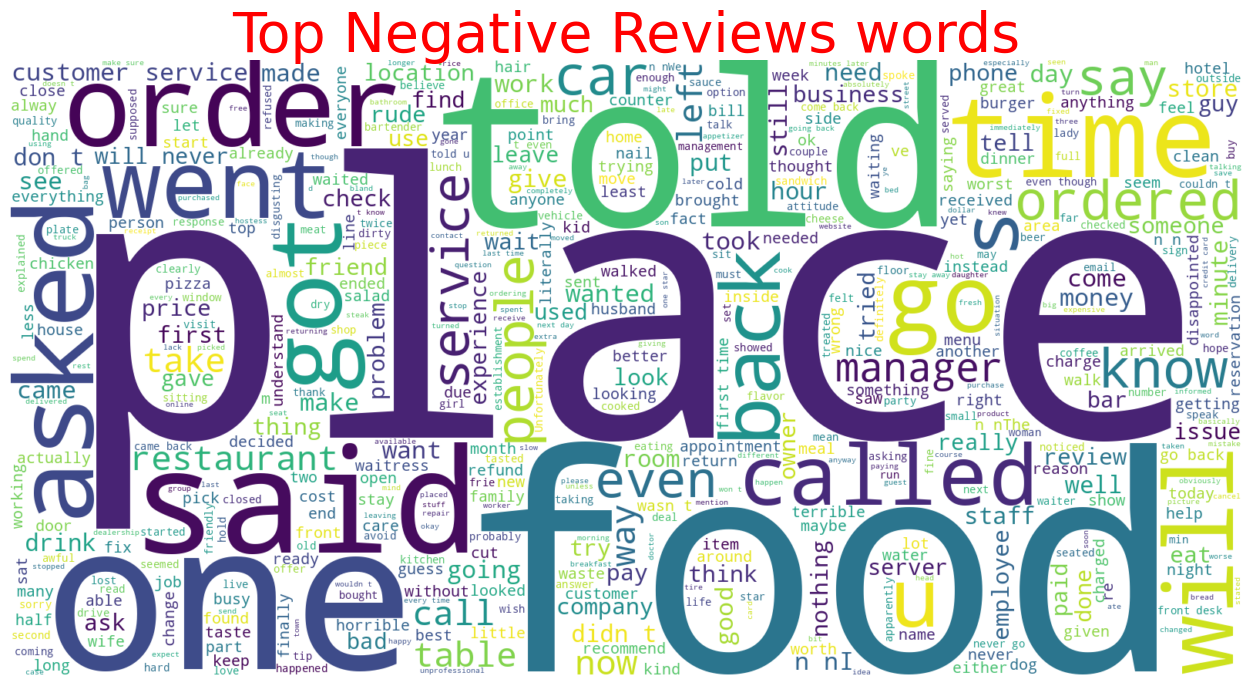

In [153]:
negative_reviews = pd.DataFrame.from_dict([d for d in dataset if d['stars'] == 1])
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(negative_reviews['text'])))
# declare our figure
plt.figure(figsize=(20,10))
plt.title("Top Negative Reviews words", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()